# Animal-10

Animal pictures of 10 different categories taken from google images


## About Dataset
Hello everyone!

This is the dataset I have used for my matriculation thesis.

It contains about 28K medium quality animal images belonging to 10 categories: dog, cat, horse, spyder, butterfly, chicken, sheep, cow, squirrel, elephant.

I have used it to test different image recognition networks: from homemade CNNs (~80% accuracy) to Google Inception (98%). It could simulate a smart gallery for a researcher (like a biologist).

All the images have been collected from "google images" and have been checked by human. There is some erroneous data to simulate real conditions (eg. images taken by users of your app).

The main directory is divided into folders, one for each category. Image count for each category varies from 2K to 5 K units.

i run my notebook un colab so first we need to download and unzip dataset 

if you want to run on your won computer you can dlownload data from link
[Animal-10](https://www.kaggle.com/datasets/alessiocorrado99/animals10/download?datasetVersionNumber=2)

In [ ]:

! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d alessiocorrado99/animals10
! unzip /content/animals10.zip -d /content/animal


In [4]:
import os
import numpy as np
import matplotlib.pyplot as plt
import shutil

import tensorflow as tf
from tensorflow.keras.layers import Rescaling, Dense, Input, Conv2D, BatchNormalization, MaxPool2D, ReLU, GlobalAveragePooling2D, Flatten, Dropout, ELU
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import to_categorical

In [5]:
# get all images full path

data_path = []

data_dir = '/content/animal/raw-img'
for root, dirs, files in os.walk(data_dir):
    for name in files:
        data_path.append(os.path.join(root, name))

print(data_path[:10])

#  shuffle the data befor spliting

np.random.shuffle(data_path)
print(data_path[:10])

['/content/animal/raw-img/elefante/OIP-LEPbFwJKw3plc1-mrSzfRwHaE2.jpeg', '/content/animal/raw-img/elefante/OIP-IxTEnS4XVys704dW2idZ6AHaE8.jpeg', '/content/animal/raw-img/elefante/OIP-pZTeF1ca-j7NwecmK-cEAAHaEs.jpeg', '/content/animal/raw-img/elefante/OIP-SqD6BXrR_A4Q4Z7Xj353DQHaE8.jpeg', '/content/animal/raw-img/elefante/OIP-eOuoCsdfcco8OgTLQgyFtwHaE7.jpeg', '/content/animal/raw-img/elefante/OIP-GY5nQytlOPULX4HBQ4YCyAHaEK.jpeg', '/content/animal/raw-img/elefante/eb3db60e2cf3073ed1584d05fb1d4e9fe777ead218ac104497f5c978a4eebdbd_640.jpg', '/content/animal/raw-img/elefante/e837b90b2afc043ed1584d05fb1d4e9fe777ead218ac104497f5c978a4eebdbd_640.jpg', '/content/animal/raw-img/elefante/OIP-lfbh1jMqzBjNsWtPGvv8gQHaFa.jpeg', '/content/animal/raw-img/elefante/OIP-3k_ZBVOd3Ozz6vh1fVHFGAHaEK.jpeg']
['/content/animal/raw-img/elefante/OIP-UKtQVGamcZkEJoeOxZStugHaK0.jpeg', '/content/animal/raw-img/pecora/OIP-sjK-C6031IcBa21QWC4znQHaFj.jpeg', '/content/animal/raw-img/cane/OIP-iAm9M9ZQ1YsOe9uf9OrbVgHaGF.j

In [6]:
len(data_path)

26179

In [7]:
# create copy def

def create_data(array, train_p, val_p, test_p, path):
    """
    create a train & test & validation directory structure like:

    dir :
    -- train:
            img1
            img2
            ...
    -- validation:
            img1
            img2
            ...
    -- test:
            img1
            img2
            ...
    
    params:
        array : list of images path
        train_p : train persent value
        val_p : validation persent value
        test_p : test persent value
        path : where create the structure (nwe path)

    """

    # calculate the persent of each subset
    tp = len(array) * train_p // 100
    vp = len(array) * val_p // 100
    testp = len(array) * test_p // 100

    # condetional selecting for eath subset 
    train_list = array[:tp]
    val_list = array[tp:tp+vp]
    test_list = array[tp + vp :]

    print('train_list : ', len(train_list), 'images val_list : ', len(val_list), 'images test_list : ', len(test_list), 'images')

    for i in train_list:
        
        dir_name = i.split('/')[-2]
        train_path = path + '/train'

        os.makedirs(os.path.join(train_path, dir_name), exist_ok=True)
        # print(os.path.join(train_path , dir_name))
        shutil.copy(i, os.path.join(train_path, dir_name))
    print('train done')

    for i in val_list:
        
        dir_name = i.split('/')[-2]
        validation_path = path + '/validation'
        
        os.makedirs(os.path.join(validation_path, dir_name), exist_ok=True)
        # print(os.path.join(validation_path , dir_name))
        shutil.copy(i, os.path.join(validation_path, dir_name))
    print('validation done')

    for i in test_list:
        
        dir_name = i.split('/')[-2]
        test_path = path + '/test'
        
        os.makedirs(os.path.join(test_path, dir_name), exist_ok=True)
        # print(os.path.join(test_path , dir_name))
        shutil.copy(i, os.path.join(test_path, dir_name))
    print('test done')

    

In [8]:
create_data(data_path, 80, 10, 10, 'animal_data_cr')

train_list :  20943 images val_list :  2617 images test_list :  2619 images
train done
validation done
test done


In [9]:
# create train, validation data generators

train_data_gen = ImageDataGenerator(
    rescale=1/255.,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
)

validation_data_gen = ImageDataGenerator(
    rescale=1./255,)

In [10]:
# flow_from_directory

train_data = train_data_gen.flow_from_directory(
    directory='/content/animal_data_cr/train',
    batch_size = 32,
    target_size=(224, 224),
    subset = 'training'
)

validation_data = validation_data_gen.flow_from_directory(
    directory = '/content/animal_data_cr/validation',
    batch_size = 32,
    target_size = (224, 244)
)

Found 20943 images belonging to 10 classes.
Found 2617 images belonging to 10 classes.


In [22]:
translate = {"cane": "dog", "cavallo": "horse", "elefante": "elephant", "farfalla": "butterfly", "gallina": "chicken", "gatto": "cat", "mucca": "cow", "pecora": "sheep", "scoiattolo": "squirrel", "cavallo": "horse", "ragno": "spider"}
classes = {str(y): x for x, y in train_data.class_indices.items()}
classes

{'0': 'cane',
 '1': 'cavallo',
 '2': 'elefante',
 '3': 'farfalla',
 '4': 'gallina',
 '5': 'gatto',
 '6': 'mucca',
 '7': 'pecora',
 '8': 'ragno',
 '9': 'scoiattolo'}

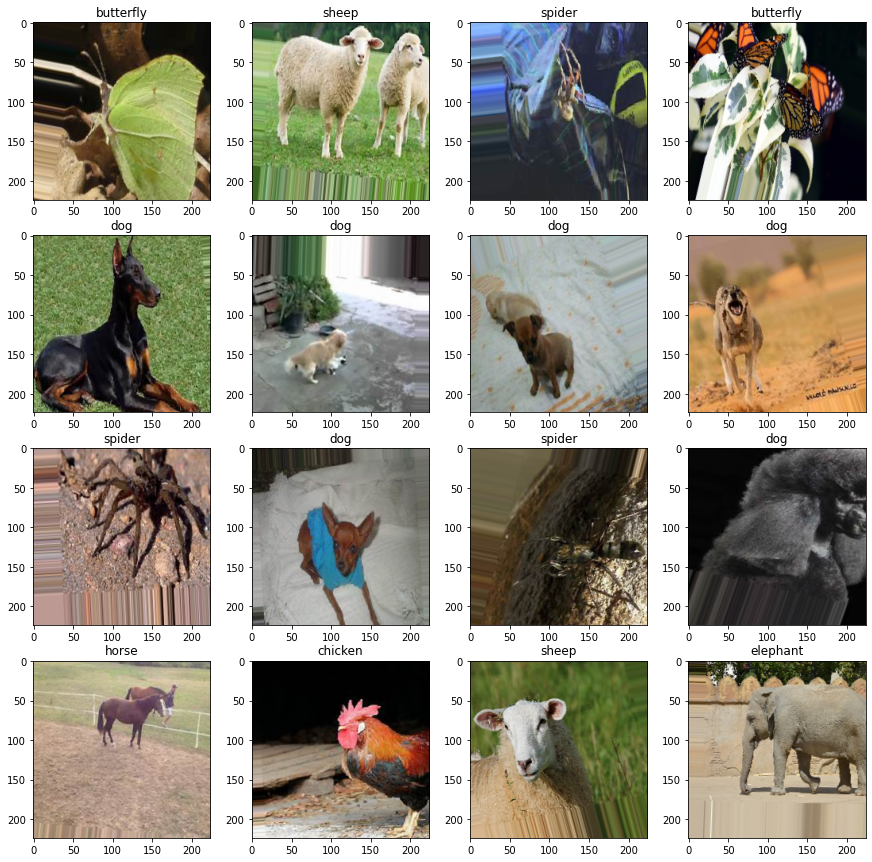

In [11]:

plt.figure(figsize=(15, 15))
for i in range(16):
    plot = plt.subplot(4,4,i+1)
    img, label = train_data.next()
    plot.imshow(img[0])
    label_index = list(label[0]).index(1)
    plot.set_title(translate[classes[str(label_index)]])

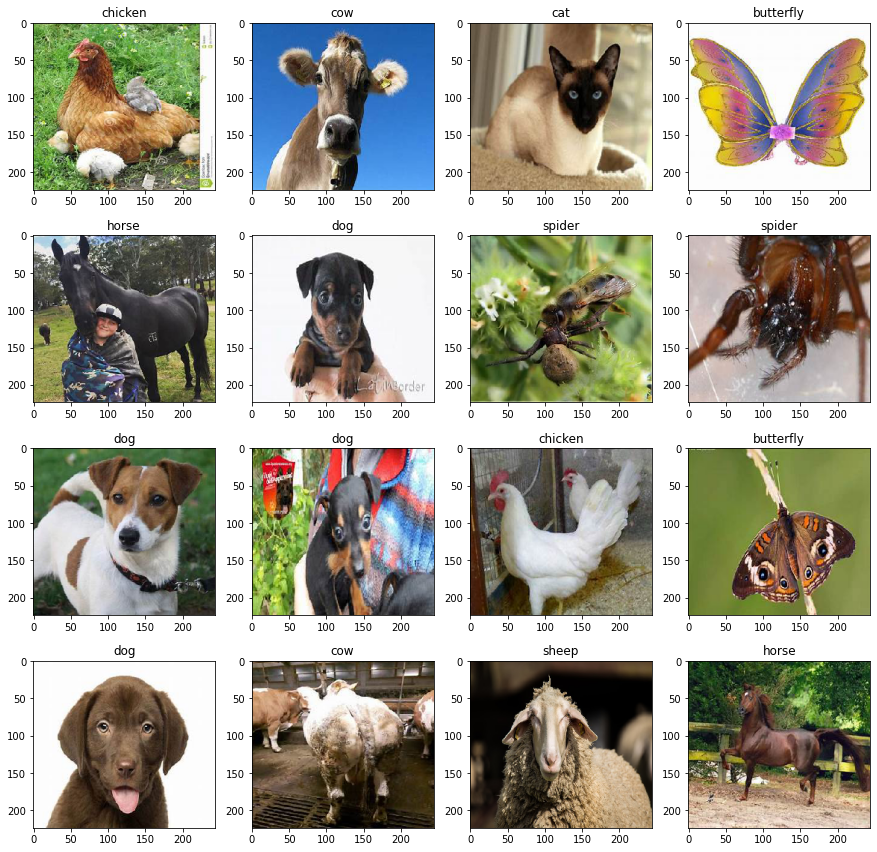

In [12]:
plt.figure(figsize=(15, 15))
for i in range(16):
    plot = plt.subplot(4,4,i+1)
    img, label = validation_data.next()
    plot.imshow(img[0])
    label_index = list(label[0]).index(1)
    plot.set_title(translate[classes[str(label_index)]])

In [13]:
# create model from transfer learning

base_model = tf.keras.applications.VGG16(
    include_top = False,
    weights = 'imagenet',
    input_shape = (224,224,3)
)

i = base_model.input

# delet the last max_pool layer from base model after looking the base model summary

x = base_model.layers[-2].output
x = GlobalAveragePooling2D()(x)
fc1 = Dense(units = 256, activation ='relu')(x)
o = Dense(units = 10, activation ='softmax')(fc1)

model = Model(i, o)

model.summary()


58900480/58889256 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

In [47]:
# callbacks
earlystop = tf.keras.callbacks.EarlyStopping(patience=30, restore_best_weights=True, verbose=1)

model_checkpoint = ModelCheckpoint('/content/drive/MyDrive/animal_model_cnn.h5', monitor='val_loss', save_best_only=True, verbose=1)

reduse_learing_rate = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.1,
    patience=5,
    verbose=1,
    mode="auto",
    min_delta=0.0001,
    cooldown=0,
    min_lr=0.00000001,
)

# complie the model
model.compile(optimizer=Adam(learning_rate = 0.00001), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model.fit(train_data, validation_data=validation_data, epochs=40, callbacks=[earlystop, model_checkpoint, reduse_learing_rate ])

Epoch 1/40
655/655 [==============================] - ETA: 0s - loss: 0.0289 - accuracy: 0.9921
Epoch 1: val_loss improved from inf to 0.16079, saving model to /content/drive/MyDrive/animal_model_cnn.h5
655/655 [==============================] - 368s 558ms/step - loss: 0.0289 - accuracy: 0.9921 - val_loss: 0.1608 - val_accuracy: 0.9591 - lr: 1.0000e-05
Epoch 2/40
655/655 [==============================] - ETA: 0s - loss: 0.0181 - accuracy: 0.9947
Epoch 2: val_loss did not improve from 0.16079
655/655 [==============================] - 363s 553ms/step - loss: 0.0181 - accuracy: 0.9947 - val_loss: 0.1692 - val_accuracy: 0.9614 - lr: 1.0000e-05
Epoch 3/40
655/655 [==============================] - ETA: 0s - loss: 0.0164 - accuracy: 0.9951
Epoch 3: val_loss did not improve from 0.16079
655/655 [==============================] - 362s 553ms/step - loss: 0.0164 - accuracy: 0.9951 - val_loss: 0.1756 - val_accuracy: 0.9652 - lr: 1.0000e-05
Epoch 4/40
655/655 [==============================] - E

### after **train and** sava the model let load the model and see if it can detect a *custom image* 

# evaluate the model

In [ ]:
model = tf.keras.models.load_model('/content/drive/MyDrive/animal_model_cnn.h5')

test_data = validation_data_gen.flow_from_directory(
    directory = '/content/animal_data_cr/test',
    batch_size = 32,
    target_size = (224, 244)
)

Found 2619 images belonging to 10 classes.


In [ ]:
model.evaluate(test_data)

82/82 [==============================] - 30s 203ms/step - loss: 0.0502 - accuracy: 0.9874


[0.05024542286992073, 0.9873997569084167]

In [23]:
import cv2 as cv
model = tf.keras.models.load_model('/content/drive/MyDrive/animal_model_cnn.h5')
def predection_def(img_path):

    img = cv.imread(img_path)
    img = cv.resize(img, (224, 224))
    img_p = img.reshape((1, 224, 224, 3)).astype('float32') /255.
    
    # model = tf.keras.models.load_model('/content/drive/MyDrive/animal_model_cnn.h5')
    
    pred_label = list(np.round(model.predict(img_p))[0]).index(1)
    

    plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))

    plt.xlabel(translate[classes[str(pred_label)]],fontsize=20)



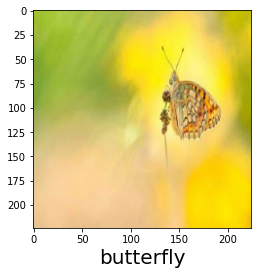

In [25]:
predection_def('/content/121111.jpg')

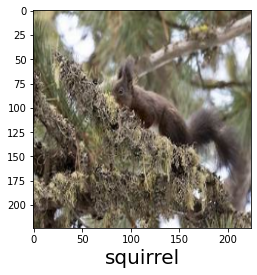

In [30]:
predection_def('/content/animal_data_cr/test/scoiattolo/OIP-5TUietm2o3z-jNDHiuKKfQHaE7.jpeg')